In [1]:
import os
import sys
# SRC_DIR environment variable should be the absolute path to the 'multicopy-STR-genotyping' directory
sys.path.append(os.environ["SRC_DIR"])

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from multicopy_STR_genotyping import file_io

sns.set_context("poster")
%matplotlib inline

In [3]:
vcf = "../../../data/HG002/variants/HipSTR/2024-07-08_hg002_HipSTR_filt.vcf" # str: path to input vcf file                      
vcf_format = "HipSTR" # str: which tool was used to genotype
sample = "HG002" # str: name of sample in vcf to analyse
set_cn = True # bool: set CN of loci manually (based on chromosome name)
gt_in_bp = True # bool: does the tool report genotypes in bp (True) or in number of repeat units (False)
strs_covered_by_haplotypes = "../../../data/HG002/regions/hg38_ver13_0boe_mononucleotides_union.bed" # str: path to bed with loci that are covered by the haplotypes provided by Q100
haplotype_str_length = "../../../data/HG002/variants/HG002_GRCh38_STR_lengths.csv" # str: path to csv with STR allele lengths based on Q100 haplotypes
comparison_file_out = None # None or str: path to write csv with comparison of STR allele lengths from vcf to Q100 STR allele lengths


In [4]:
def set_cn_manually(df):
    autosomes = [f"chr{i}" for i in range(1, 23)]
    df = df.assign(
        copy_number = lambda x: [2 if i in autosomes else 1 for i in x["chr"]]
    )
    return df

In [5]:
df_repeats, df_hg002 = file_io.dfs_from_vcf(filename=vcf, samples=[sample], vcf_format=vcf_format)
print(df_repeats.shape, df_hg002.shape)

df_covered_repeats = pd.read_csv(strs_covered_by_haplotypes, sep="\t", names=["chr", "start", "end", "period", "unit"])
df_covered_repeats = df_covered_repeats.assign(
            str_id = np.array([f"{chrom}_{start + 1}" for chrom, start in zip(df_covered_repeats.chr, df_covered_repeats.start)])
)

df_covered_repeats = df_repeats[df_repeats["str_id"].isin(df_covered_repeats["str_id"])]

df_hg002 = df_hg002.merge(
    df_covered_repeats[["str_id", "chr", "start", "end", "period", "unit", "ref"]], on="str_id", how="inner"
)

if set_cn:
    df_hg002 = set_cn_manually(df_hg002)
    
df_hg002 = df_hg002.dropna().reset_index(drop=True)

print(df_covered_repeats.shape, df_hg002.shape)

df_hg002


(1266201, 7) (1266201, 5)
(1223569, 7) (1223466, 11)


,sample,str_id,copy_number,frequencies,genotype,chr,start,end,period,unit,ref
0,HG002,chr1_588068,2,{12: 22},"[12, 12]",chr1,588068,588079,3,CCT,12
1,HG002,chr1_590659,2,{12: 56},"[12, 12]",chr1,590659,590670,4,AAAT,12
2,HG002,chr1_590969,2,{16: 38},"[16, 16]",chr1,590969,590984,4,AAAC,16
3,HG002,chr1_594083,2,{12: 21},"[12, 12]",chr1,594083,594094,3,TCC,12
4,HG002,chr1_597686,2,"{14: 33, 17: 1}","[14, 14]",chr1,597686,597699,1,A,14
...,...,...,...,...,...,...,...,...,...,...,...
1223461,HG002,chrY_26622472,1,{10: 28},"[10, 10]",chrY,26622472,26622481,5,AAATA,10
1223462,HG002,chrY_26627699,1,{12: 24},"[12, 12]",chrY,26627699,26627710,3,GAA,12
1223463,HG002,chrY_26628607,1,{15: 31},"[15, 15]",chrY,26628607,26628621,5,ATTTT,15
1223464,HG002,chrY_26635262,1,{10: 35},"[10, 10]",chrY,26635262,26635271,1,A,10


In [6]:
sex_chromosomes = ((df_hg002["chr"] == 'chrX') | (df_hg002["chr"] == 'chrY'))

updated_gts = list(df_hg002[~sex_chromosomes]["genotype"])
for gt in df_hg002.loc[sex_chromosomes]["genotype"]:
    if gt[0] == gt[1]:
        updated_gts.append([gt[0]])
    else:
        updated_gts.append(np.nan)

df_hg002["genotype"] = updated_gts
df_hg002 = df_hg002.dropna(axis=0, subset="genotype").reset_index(drop=True)
df_hg002

,sample,str_id,copy_number,frequencies,genotype,chr,start,end,period,unit,ref
0,HG002,chr1_588068,2,{12: 22},"[12, 12]",chr1,588068,588079,3,CCT,12
1,HG002,chr1_590659,2,{12: 56},"[12, 12]",chr1,590659,590670,4,AAAT,12
2,HG002,chr1_590969,2,{16: 38},"[16, 16]",chr1,590969,590984,4,AAAC,16
3,HG002,chr1_594083,2,{12: 21},"[12, 12]",chr1,594083,594094,3,TCC,12
4,HG002,chr1_597686,2,"{14: 33, 17: 1}","[14, 14]",chr1,597686,597699,1,A,14
...,...,...,...,...,...,...,...,...,...,...,...
1223203,HG002,chrY_26622472,1,{10: 28},[10],chrY,26622472,26622481,5,AAATA,10
1223204,HG002,chrY_26627699,1,{12: 24},[12],chrY,26627699,26627710,3,GAA,12
1223205,HG002,chrY_26628607,1,{15: 31},[15],chrY,26628607,26628621,5,ATTTT,15
1223206,HG002,chrY_26635262,1,{10: 35},[10],chrY,26635262,26635271,1,A,10


In [7]:
df_in_segdup = pd.read_csv("../../../data/hg38_ver13_0boe_mononucleotides_in_segdup.bed", sep="\t", names=["chr", "start", "end", "period", "unit"])
df_in_segdup = df_in_segdup.assign(str_id = lambda x: [f"{i}_{j + 1}" for i, j in zip(x["chr"], x["start"])])

df_hg002 = df_hg002[~df_hg002["str_id"].isin(df_in_segdup["str_id"])].reset_index(drop=True)
df_hg002.shape

(1174890, 11)

In [8]:
if gt_in_bp:
    df_hg002 = df_hg002.assign(
        illumina_region_len = lambda x: [sorted(gt) for gt in x["genotype"]],
        depth = lambda x: [sum(i.values()) for i in x["frequencies"]],
    )
else:
    df_hg002 = df_hg002.assign(
        illumina_region_len = lambda x: [sorted([k * j for k in i]) for i, j in zip(x["genotype"], x["period"])],
        depth = lambda x: [sum(i.values()) for i in x["frequencies"]],
    )
    
df_hg002

,sample,str_id,copy_number,frequencies,genotype,chr,start,end,period,unit,ref,illumina_region_len,depth
0,HG002,chr1_902774,2,"{1: 1, 13: 3, 14: 58, 15: 2}","[14, 14]",chr1,902774,902788,1,A,15,"[14, 14]",64
1,HG002,chr1_904440,2,{9: 52},"[9, 9]",chr1,904440,904448,3,CTC,9,"[9, 9]",52
2,HG002,chr1_904654,2,{12: 43},"[12, 12]",chr1,904654,904665,3,CCT,12,"[12, 12]",43
3,HG002,chr1_907237,2,"{13: 1, 14: 48}","[14, 14]",chr1,907237,907250,1,A,14,"[14, 14]",49
4,HG002,chr1_919012,2,{12: 48},"[12, 12]",chr1,919012,919023,4,GCAG,12,"[12, 12]",48
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1174885,HG002,chrY_26487819,1,"{9: 1, 10: 28}",[10],chrY,26487819,26487828,1,A,10,[10],29
1174886,HG002,chrY_26487987,1,{10: 36},[10],chrY,26487987,26487996,1,A,10,[10],36
1174887,HG002,chrY_26489202,1,{12: 33},[12],chrY,26489202,26489213,4,TAAA,12,[12],33
1174888,HG002,chrY_26489935,1,{12: 23},[12],chrY,26489935,26489946,3,AGA,12,[12],23


In [9]:
df_strs_haplotypes = pd.read_csv(haplotype_str_length).assign(chr = lambda x: [i[0] for i in x["str_id"].str.split("_")])
df_strs_haplotypes

,str_id,region_len_ref,region_len_mat,region_len_pat,chr
0,chr1_588068,12,12.0,12.0,chr1
1,chr1_589245,12,12.0,12.0,chr1
2,chr1_590659,12,12.0,12.0,chr1
3,chr1_590969,16,16.0,16.0,chr1
4,chr1_591734,18,20.0,20.0,chr1
...,...,...,...,...,...
1695860,chrY_57188868,11,NaN,11.0,chrY
1695861,chrY_57200838,14,NaN,15.0,chrY
1695862,chrY_57201000,20,NaN,20.0,chrY
1695863,chrY_57202381,23,NaN,23.0,chrY


In [10]:
autosomes = "chr != 'chrX' and chr != 'chrY'"
X = "chr == 'chrX'"
Y = "chr == 'chrY'"

df_strs_haplotypes["haplo_region_len"] = [[] for i in range(len(df_strs_haplotypes))]

df_strs_haplotypes.loc[df_strs_haplotypes.eval(autosomes), "haplo_region_len"] = pd.Series([
    sorted([np.int64(i), np.int64(j)]) for i, j in zip(
        df_strs_haplotypes.loc[df_strs_haplotypes.eval(autosomes), "region_len_mat"], 
        df_strs_haplotypes.loc[df_strs_haplotypes.eval(autosomes), "region_len_pat"],)])

for i, j in zip(
        df_strs_haplotypes.loc[df_strs_haplotypes.eval(X), "haplo_region_len"],
        df_strs_haplotypes.loc[df_strs_haplotypes.eval(X), "region_len_mat"]):
    i.append(np.int64(j))
    
for i, j in zip(
        df_strs_haplotypes.loc[df_strs_haplotypes.eval(Y), "haplo_region_len"],
        df_strs_haplotypes.loc[df_strs_haplotypes.eval(Y), "region_len_pat"]):
    i.append(np.int64(j))
    
df_strs_haplotypes

,str_id,region_len_ref,region_len_mat,region_len_pat,chr,haplo_region_len
0,chr1_588068,12,12.0,12.0,chr1,"[12, 12]"
1,chr1_589245,12,12.0,12.0,chr1,"[12, 12]"
2,chr1_590659,12,12.0,12.0,chr1,"[12, 12]"
3,chr1_590969,16,16.0,16.0,chr1,"[16, 16]"
4,chr1_591734,18,20.0,20.0,chr1,"[20, 20]"
...,...,...,...,...,...,...
1695860,chrY_57188868,11,NaN,11.0,chrY,[11]
1695861,chrY_57200838,14,NaN,15.0,chrY,[15]
1695862,chrY_57201000,20,NaN,20.0,chrY,[20]
1695863,chrY_57202381,23,NaN,23.0,chrY,[23]


In [11]:
df_comparison = (
    df_strs_haplotypes[["str_id", "haplo_region_len"]]
        .merge(df_hg002[["str_id", "illumina_region_len", "depth", "copy_number", "period"]], on="str_id", how="inner")
        .assign(
            match = lambda x: x["haplo_region_len"] == x["illumina_region_len"],
        )
)

df_comparison

,str_id,haplo_region_len,illumina_region_len,depth,copy_number,period,match
0,chr1_902774,"[14, 14]","[14, 14]",64,2,1,True
1,chr1_904440,"[9, 9]","[9, 9]",52,2,3,True
2,chr1_904654,"[12, 12]","[12, 12]",43,2,3,True
3,chr1_907237,"[14, 14]","[14, 14]",49,2,1,True
4,chr1_919012,"[12, 12]","[12, 12]",48,2,4,True
...,...,...,...,...,...,...,...
1174885,chrY_26487819,[10],[10],29,1,1,True
1174886,chrY_26487987,[10],[10],36,1,1,True
1174887,chrY_26489202,[12],[12],33,1,4,True
1174888,chrY_26489935,[12],[12],23,1,3,True


In [12]:
if comparison_file_out:
    df_comparison.to_csv(comparison_file_out, index=False)

In [13]:
n_wrong = df_comparison.loc[~df_comparison["match"]].shape[0]
n_total = df_comparison.shape[0]

print(f"n correct: {n_total - n_wrong}, n wrong: {n_wrong}, n total: {n_total}")
print("Overall accuracy:", (1 - (n_wrong / n_total)) * 100)

df_comparison.loc[~df_comparison["match"]]

n correct: 1148280, n wrong: 26610, n total: 1174890
Overall accuracy: 97.7351071164109


,str_id,haplo_region_len,illumina_region_len,depth,copy_number,period,match
43,chr1_1013043,"[9, 9]","[12, 12]",72,2,3,False
49,chr1_1048768,"[11, 11]","[13, 13]",28,2,1,False
63,chr1_1081643,"[11, 12]","[10, 11]",56,2,5,False
385,chr1_1913490,"[15, 15]","[15, 16]",65,2,5,False
396,chr1_1949126,"[20, 20]","[24, 25]",19,2,4,False
...,...,...,...,...,...,...,...
1174331,chrY_19691792,[29],[43],1,1,1,False
1174604,chrY_20731420,[61],[60],27,1,4,False
1174662,chrY_20879313,[33],[34],1,1,1,False
1174812,chrY_21319948,[10],[15],34,1,1,False


In [14]:
min_depth = 15
max_depth = 85
query = f"depth / copy_number >= {min_depth} and depth / copy_number <= {max_depth}"

n_wrong = df_comparison.query(query).loc[~df_comparison.query(query)["match"]].shape[0]
n_total = df_comparison.query(query).shape[0]

print(f"n correct: {n_total - n_wrong}, n wrong: {n_wrong}, n total: {n_total}")
print("Overall accuracy:", (1 - (n_wrong / n_total)) * 100)

n correct: 1129186, n wrong: 23564, n total: 1152750
Overall accuracy: 97.95584471914985


In [15]:
df_plot = pd.DataFrame(
    np.concatenate([np.repeat([1, 2, 3, 4, 5, 6], 7).reshape(-1, 1), np.tile([1, 5, 5, 10, 10, 15, 15, 20, 20, 25, 25, 30, 30, 1e6], 6).reshape(-1, 2)], axis=1),
    columns=["period", "depth_lower", "depth_upper"]
)

accuracy = []
n = []
for row in df_plot.to_dict(orient="records"):
    selected_loci = (
        df_comparison
            .assign(depth = lambda x: x["depth"] / x["copy_number"])
            .query(f"depth >= {row['depth_lower']} and depth < {row['depth_upper']} and period == {row['period']}")["str_id"]
    )
    df_comparison_filt = df_comparison.loc[df_comparison["str_id"].isin(selected_loci)]
    n.append(df_comparison_filt.shape[0])
    accuracy.append((1 - (df_comparison_filt.loc[~df_comparison_filt["match"]].shape[0] / df_comparison_filt.shape[0])) * 100)

df_plot["n"] = n
df_plot["accuracy"] = accuracy
df_plot["depth"] = np.tile(["1-5", "5-10", "10-15", "15-20", "20-25", "25-30", "30-"], 6)

In [16]:
for name, data in df_plot.groupby("depth"):
    print(name, np.average(data["accuracy"], weights=data["n"]), data["n"].sum())
print()
for name, data in df_plot.groupby("period"):
    print(name, np.average(data["accuracy"], weights=data["n"]), data["n"].sum())



1-5 60.45576407506702 1492
10-15 89.9708265802269 15425
15-20 94.25287356321839 44805
20-25 96.80738511056803 134216
25-30 97.85452326836561 298302
30- 98.47434365686723 675447
5-10 83.97691082802548 5024

1.0 97.415555928338 470933
2.0 95.66057393714406 98861
3.0 98.16482637738989 123803
4.0 98.42001873341313 307472
5.0 98.27055948769801 142416
6.0 98.54928585153398 31226


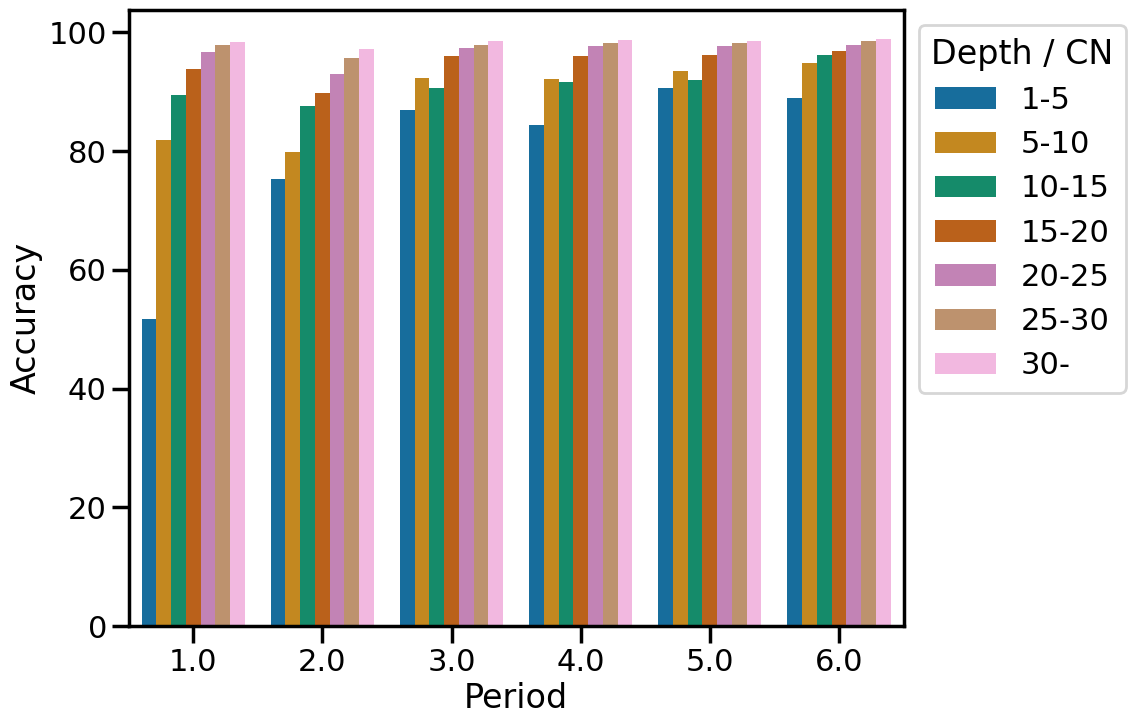

In [17]:
fig = plt.figure(figsize=(10, 8))

ax = sns.barplot(
    df_plot,
    x="period",
    y="accuracy",
    hue="depth",
    palette="colorblind"
)

ax.set(
    xlabel="Period",
    ylabel = "Accuracy"
)

_ = ax.get_legend().set(
    title="Depth / CN",
    bbox_to_anchor = (1, 1)
)

In [18]:
from scipy import ndimage

df_plot_density = (
    df_comparison
        .query("period >= 1 and period <= 6")
        .assign(depth = lambda x: x["depth"] / x["copy_number"])[["match", "period", "depth"]]
)

df_plot_smooth = (
    df_plot_density        
        .drop("period", axis=1)
        .groupby(["depth"], observed=True, as_index=False).agg(
            accuracy = ("match", lambda x: x.sum() / len(x)), 
            n_obs=("match", "count"))
        # .query(f"n_obs >= {min_obs}")
        
)

smooth = []
smooth = ndimage.gaussian_filter1d(df_plot_smooth["accuracy"], 3, mode="reflect")
df_plot_smooth = df_plot_smooth.assign(smooth = smooth)


df_plot_smooth_period = (
    df_plot_density
        .groupby(["period", "depth"], observed=True, as_index=False).agg(
            accuracy = ("match", lambda x: x.sum() / len(x)), 
            n_obs=("match", "count"))
        # .query(f"n_obs >= {min_obs}")
        
)

smooth = []
for group, data in df_plot_smooth_period.groupby(["period"]):
    current_smooth = ndimage.gaussian_filter1d(data["accuracy"], 3, mode="reflect")
    smooth.append(current_smooth)
df_plot_smooth_period = df_plot_smooth_period.assign(smooth = np.concatenate(smooth))

df_plot_smooth_period

,period,depth,accuracy,n_obs,smooth
0,1,0.5,0.184874,119,0.319651
1,1,1.0,0.272727,132,0.338048
2,1,1.5,0.261364,88,0.372302
3,1,2.0,0.404580,131,0.417977
4,1,2.5,0.508621,116,0.469828
...,...,...,...,...,...
832,6,68.5,1.000000,1,1.000000
833,6,72.0,1.000000,1,1.000000
834,6,73.0,1.000000,1,1.000000
835,6,73.5,1.000000,1,1.000000


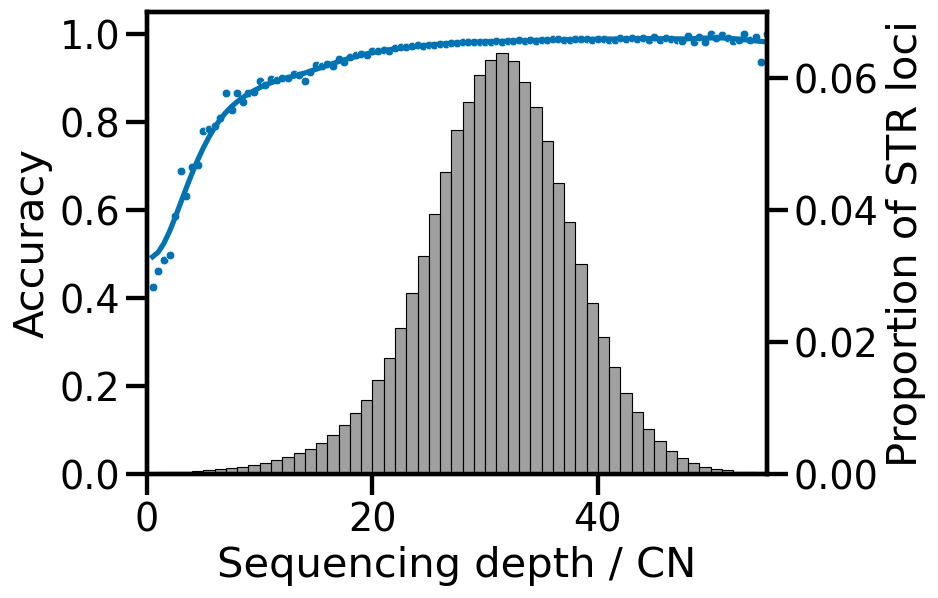

In [19]:
fig = plt.figure(dpi=125)

ax = sns.lineplot(
    df_plot_smooth,
    x = "depth",
    y = "smooth",
    color=sns.color_palette("colorblind")[0],
    # linewidth=2,
    legend=False
)

ax = sns.scatterplot(
    df_plot_smooth,
    x = "depth",
    y = "accuracy",
    color=sns.color_palette("colorblind")[0],
    s=25,
    ax = ax,
    legend=False
)

ax.set(
    xlabel = "Sequencing depth / CN",
    ylabel = "Accuracy",
    ylim = (0, 1.05),
    xlim = (0, 55)
)

ax2 = ax.twinx()
ax2 = sns.histplot(
    df_plot_density,
    x = "depth",
    discrete=True,
    stat="proportion",
    color="grey",
    ax=ax2,
)
ax2.set(
    ylabel="Proportion of STR loci",
    ylim=(0, 0.07),
)

plt.show()

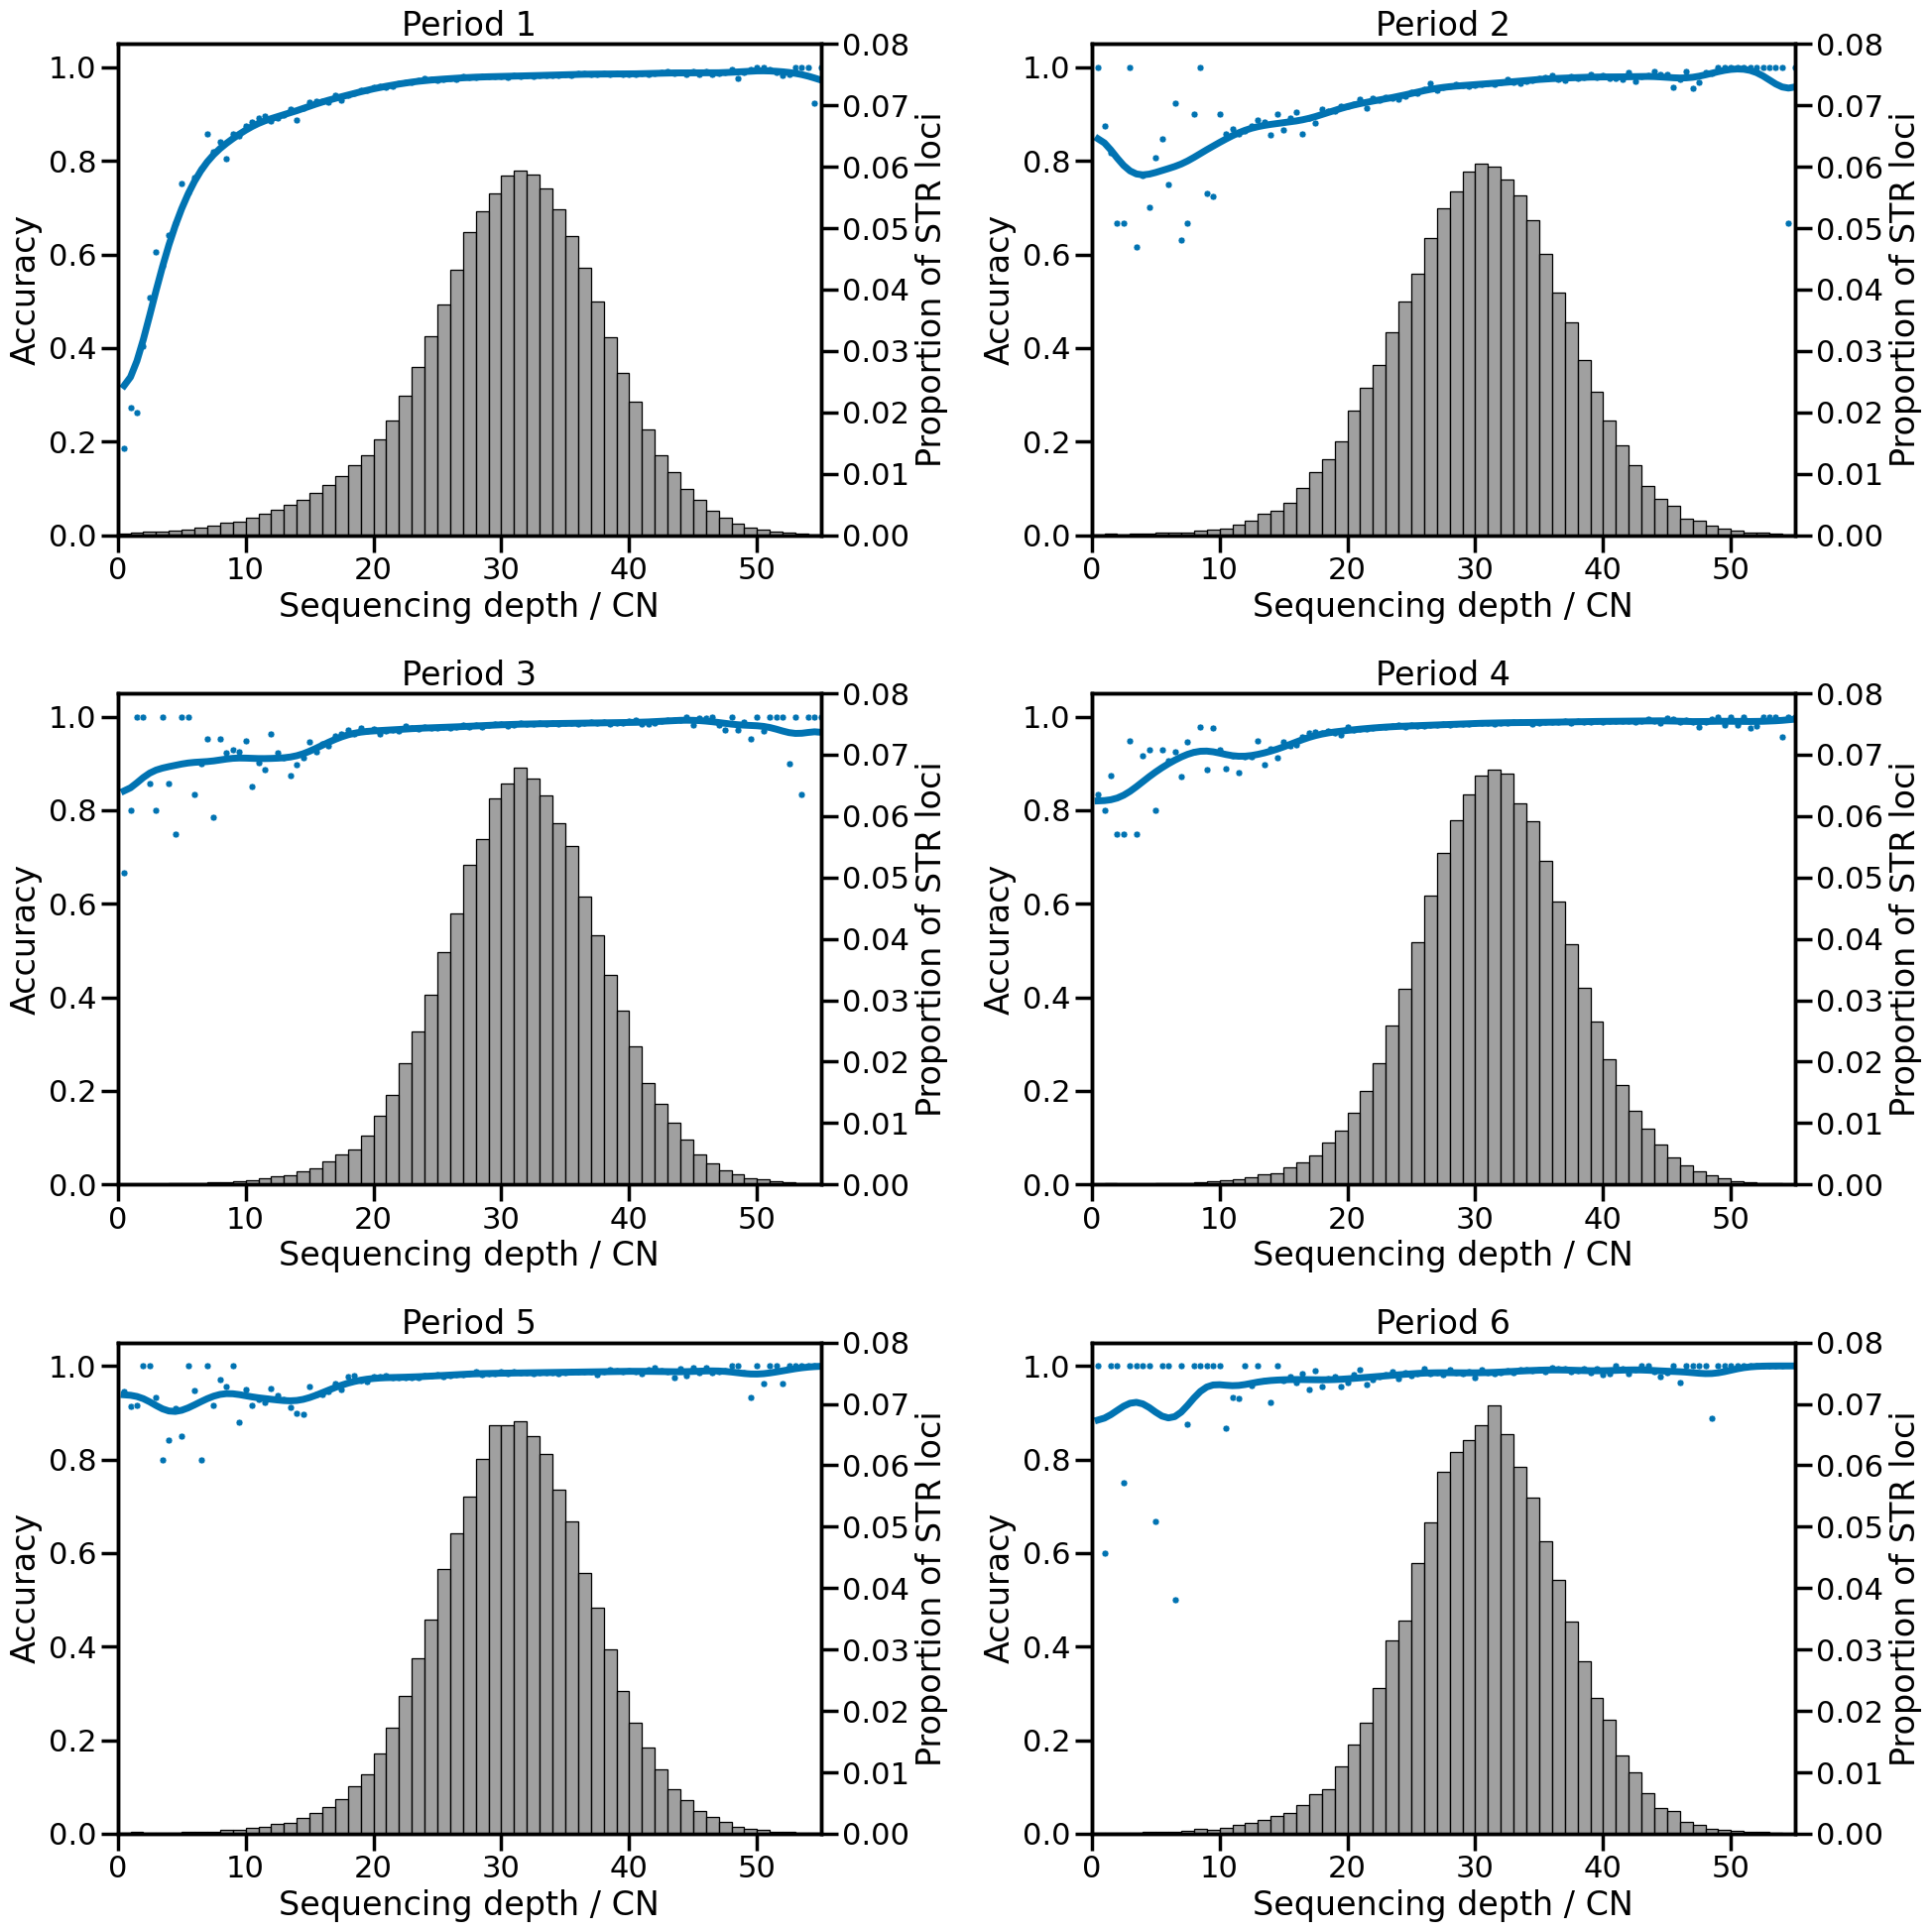

In [20]:
fig, axes = plt.subplots(3, 2, figsize=(20, 20))

for period, ax in zip(range(1, 7), axes.ravel()):
    df_subplot = (df_plot_smooth_period
                  .query(f"period == {period}"))

    ax = sns.lineplot(
        df_subplot,
        x = "depth",
        y = "smooth",
        color=sns.color_palette("colorblind")[0],
        linewidth=5,
        ax = ax,
    )

    ax = sns.scatterplot(
        df_subplot,
        x = "depth",
        y = "accuracy",
        color=sns.color_palette("colorblind")[0],
        s=25,
        ax = ax,
    )

    ax.set(
        title = f"Period {period}",
        xlabel = "Sequencing depth / CN",
        ylabel = "Accuracy",
        ylim = (0, 1.05),
        xlim = (0, 55)
    )
    
    ax2 = ax.twinx()
    ax2 = sns.histplot(
        df_plot_density.query(f"period == {period}"),
        x = "depth",
        discrete=True,
        stat="proportion",
        color="grey",
        ax=ax2,
    )
    
    ax2.set(
        ylabel="Proportion of STR loci",
        ylim=(0, 0.08),
    )

plt.tight_layout()